In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using LaTeXStrings
using Bessels
using Cubature
using FastTransforms
using LoopVectorization
using FFTW
using NPZ
using Interpolations
using TwoFAST
using QuadOsc
using FunctionZeros

In [5]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy");

In [6]:
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [11]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
k = pk_dict["k"]
z = pk_dict["z"];

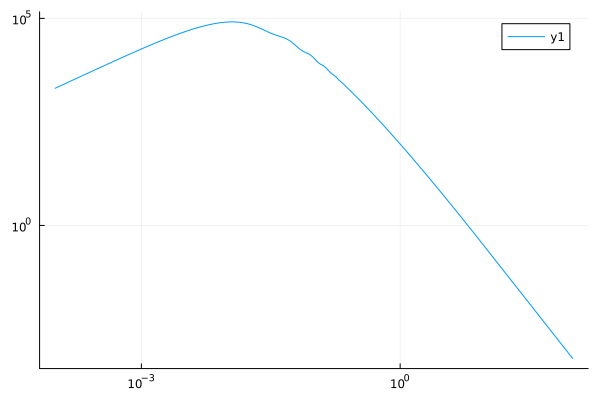

In [12]:
plot(k, Pklin[1,:], xscale=:log10, yscale=:log10)

In [13]:
y = LinRange(log10(first(k)),
log10(last(k)), length(k))


x = LinRange(first(z), last(z),
length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [14]:
myPk(k, χ1, χ2) = sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)))

myPk (generic function with 1 method)

In [15]:
nχ = 100
ℓ = 5
χ = LinRange(13, 7000, nχ);

In [16]:
function integral!(result, f, kmin, kmax, i, j)
    #int, _ = HCubature.hquadrature(f, kmin, kmax; rtol=sqrt(1e-11), atol=0, maxevals=Int(1e7), initdiv=1)
    int, _ = Cubature.pquadrature(f, kmin, kmax; reltol=sqrt(1e-14), maxevals=Int(2^19))#, abstol=0, maxevals=1e7)
    result[i,j] = int
    result[j,i] = int
    return nothing
end

integral! (generic function with 1 method)

In [17]:
result1 = zeros(nχ, nχ)
function my_f!!(result1, ℓ, χ, kmin, kmax, c)
    @time for i in 1:nχ
        Threads.@threads for j in i:nχ
            benchmark_f(x) = Bessels.sphericalbesselj.(ℓ, χ[i] * x) * Bessels.sphericalbesselj.(ℓ, χ[j] * x) * myPk(x, χ[i], χ[j]) * x^2
            integral!(result1, benchmark_f, kmin, kmax, i, j)
        end
        println(i)
    end
end

my_f!! (generic function with 1 method)

In [18]:
kmax = 200/13
kmin = 2.5/7000
n_cheb = 128
k = LinRange(kmin, kmax, 40000)
x = chebpoints(n_cheb, log10(kmin), log10(kmax))
c = chebinterp(((10 .^ x).^2).*myPk.(10 .^x, χ[1], χ[1]) , log10(kmin), log10(kmax));

# Sofia execute up to the previous cell...

In [14]:
nχ = 100
ℓ = 2
result1 = zeros(nχ, nχ)
my_f!!(result1, ℓ, χ, kmin, kmax, c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
 80.954350 seconds (16.19 G allocations: 241.213 GiB, 20.09% gc time, 4.54% compilation time)


In [14]:
nχ = 100
ℓ = 2
result2 = zeros(nχ, nχ)
my_f!!(result2, ℓ, χ, kmin, 2*kmax, c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
118.619941 seconds (23.67 G allocations: 352.647 GiB, 22.75% gc time)


In [15]:
difference = 1 .- result1./result2;

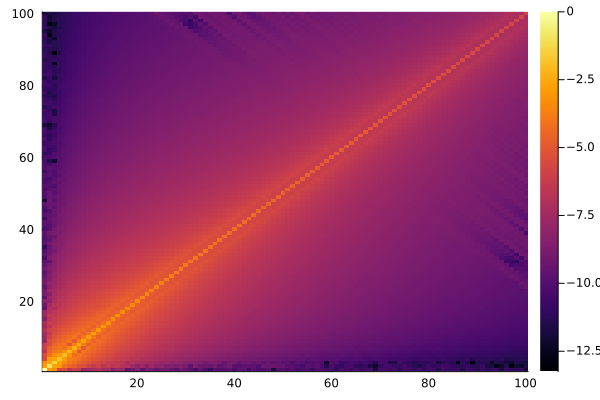

In [15]:
heatmap(log10.(abs.(result1./maximum(result1))))

In [16]:
plot(diag(result2))
plot!(diag(result1), yscale=:log10)

LoadError: UndefVarError: `result2` not defined

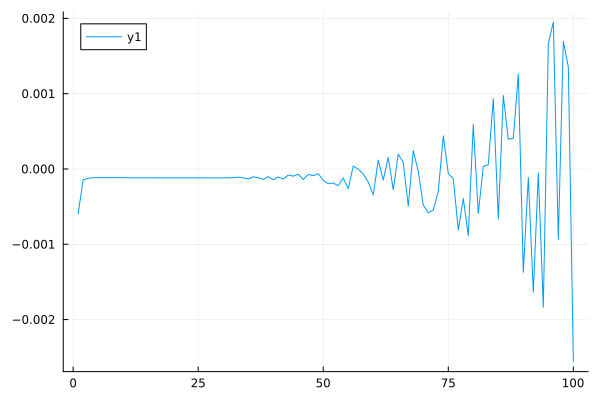

In [18]:
plot(1 .- (diag(result2)./diag(result1)))

In [17]:
function cheb_integral(n_cheb, i, j, ℓ, χ, cb)
    pippolina = zeros(n_cheb+1)
    Threads.@threads for myi in 1:n_cheb+1
        copy_cb = deepcopy(cb)
        copy_cb.coefs .*= 0
        copy_cb.coefs[myi] = 1.
        benchmark_f(x) = Bessels.sphericalbesselj.(ℓ, χ[i] * x) * Bessels.sphericalbesselj.(ℓ, χ[j] * x) *x^2 * copy_cb.(log10(x))
        #int, err = hquadrature(benchmark_f, kmin, kmax; rtol=sqrt(1e-11), atol=0, maxevals=Int(1e9), initdiv=1)
        int, _ = Cubature.pquadrature(benchmark_f, kmin*(1+1e-8), kmax; reltol=sqrt(1e-14), maxevals=Int(2^19))
        pippolina[myi] = int
    end
    return pippolina
end

function last_check(n_cheb, ℓ, χ, nχ)
    myresult = zeros(nχ, nχ)
    x = chebpoints(n_cheb, log10(kmin), log10(kmax))
    for i in 1:nχ
        for j in i:nχ
            c = chebinterp(myPk(x, χ[i], χ[j]), log10(kmin), log10(kmax))
            result = cheb_integral(n_cheb, i, j, ℓ, χ, c)
            result = dot(c.coefs, result)
            myresult[i,j] = result
            myresult[j,i] = myresult[i,j]
            println(i, " ", j)
        end
    end
    return myresult
end

function last_check_safe(n_cheb, ℓ, χ, nχ, result)
    myresult = zeros(nχ, nχ)
    x = chebpoints(n_cheb, log10(kmin), log10(kmax))
    for i in 1:nχ
        for j in i:nχ
            if result[i,j]/maximum(result) > 1e-6 || abs(i-j)<4
                
                c = chebinterp(myPk.(10 .^x, χ[i], χ[j]), log10(kmin), log10(kmax))
                myresult_float = cheb_integral(n_cheb, i, j, ℓ, χ, c)
                myresult_float = dot(c.coefs, myresult_float)
                myresult[i,j] = myresult_float
                myresult[j,i] = myresult[i,j]
                println(i, " ", j, " Computed")
            else
                println(i, " ", j, " Skipped!")
            end
        end
    end
    return myresult
end

last_check_safe (generic function with 1 method)

In [18]:
@time hope = last_check_safe(n_cheb, ℓ, χ, nχ, result1);

1 1 Computed
1 2 Computed
1 3 Computed
1 4 Computed
1 5 Skipped!
1 6 Skipped!
1 7 Skipped!
1 8 Skipped!
1 9 Skipped!
1 10 Skipped!
1 11 Skipped!
1 12 Skipped!
1 13 Skipped!
1 14 Skipped!
1 15 Skipped!
1 16 Skipped!
1 17 Skipped!
1 18 Skipped!
1 19 Skipped!
1 20 Skipped!
1 21 Skipped!
1 22 Skipped!
1 23 Skipped!
1 24 Skipped!
1 25 Skipped!
1 26 Skipped!
1 27 Skipped!
1 28 Skipped!
1 29 Skipped!
1 30 Skipped!
1 31 Skipped!
1 32 Skipped!
1 33 Skipped!
1 34 Skipped!
1 35 Skipped!
1 36 Skipped!
1 37 Skipped!
1 38 Skipped!
1 39 Skipped!
1 40 Skipped!
1 41 Skipped!
1 42 Skipped!
1 43 Skipped!
1 44 Skipped!
1 45 Skipped!
1 46 Skipped!
1 47 Skipped!
1 48 Skipped!
1 49 Skipped!
1 50 Skipped!
1 51 Skipped!
1 52 Skipped!
1 53 Skipped!
1 54 Skipped!
1 55 Skipped!
1 56 Skipped!
1 57 Skipped!
1 58 Skipped!
1 59 Skipped!
1 60 Skipped!
1 61 Skipped!
1 62 Skipped!
1 63 Skipped!
1 64 Skipped!
1 65 Skipped!
1 66 Skipped!
1 67 Skipped!
1 68 Skipped!
1 69 Skipped!
1 70 Skipped!
1 71 Skipped!
1 72 Skipped!
1

In [19]:
difference = 1 .- hope./result1;

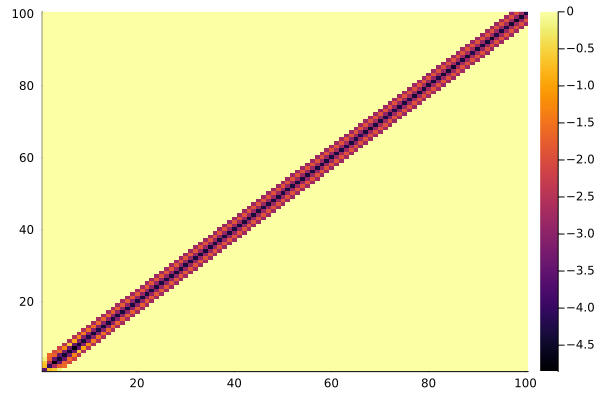

In [20]:
heatmap(log10.(abs.(difference)))

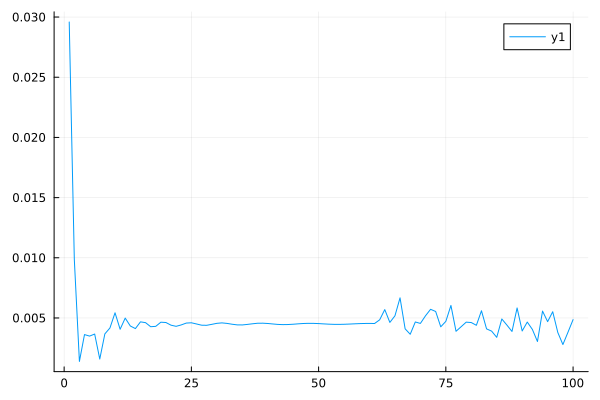

In [21]:
plot(100 .* abs.(diag(difference)))

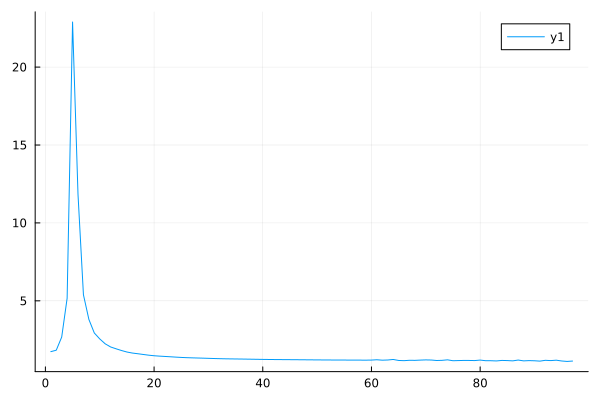

In [22]:
plot([100 .* abs.(difference)[i,i+2] for i in 2:98])

In [175]:
N = 4096
chi0 = 1e-3
kmax = 200/13
kmin = 2.5/7000
q = 1.1
ell = [5]  # only ell=42 for this run
RR = [1.0]

# calculate M_ll at high ell, result gets saved to a file:
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

# calculate wljj:
w00 = Array{Float64}(undef, N, length(RR))
w02 = Array{Float64}(undef, N, length(RR))
function outfunc(wjj, ell, rr, RR)
    if ell == 5
        w00[:,:] = wjj[1]
        w02[:,:] = wjj[2]
    end
end

  q=1.1, R=1.0:	  0.000788 seconds (8.20 k allocations: 576.281 KiB)

ℓ = 5
Δℓ = 4
ΔℓRg1 = -4
N = 4096
q = 1.1
kmin = 0.00035714285714285714
kmax = 15.384615384615385
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 0.00035714285714285714
kmax = 15.384615384615385
dlrec    = 4
dlrecRg1 = -4
Output size: 131136 bytes = 0.0001221299171447754 GiB
Output size: 131136 bytes = 0.0001221299171447754 GiB
Reading 'out/F21EllCache'...   0.000507 seconds (180 allocations: 132.109 KiB)
ellmax: 7
lmaxcache: 5
fell[:,1,1] = ComplexF64[48282.02161709104 - 1.1825684645946771e-11im, 0.0 + 0.0im]
ell 7, elapsed: 5.9604644775390625e-6
ell 6, elapsed: 4.291534423828125e-5
ell 5, elapsed: 2.9087066650390625e-5
ell 4, elapsed: 0.0002880096435546875
ell 3, elapsed: 0.000225067138671875
  0.000930 seconds (338 allocations: 17.703 KiB)
elapsed: 0.000308990478515625
step:          0.000129 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_M

outfunc (generic function with 1 method)

In [41]:
function TGA(k, ωb, ωm)
    y = k / (ωm - ωb)
    return (1 + 56.4933 * y^1.48261 + 3559.23* y^3.76407 + 4982.44 *y^5.68246 + 374.167* y^7.14558)^(-0.25)
end

function Pk(k, ωb, ωm, ns)
    return k^ns * TGA(k, ωm, ωb)^2
end

@benchmark TGA($1, $0.02, $0.1)

BenchmarkTools.Trial: 10000 samples with 961 evaluations.
 Range (min … max):  86.211 ns … 115.630 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     86.312 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   86.830 ns ±   1.460 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅█▄                                                      ▃▄▁ ▁
  ███▆▆▅▃▃▄▅▃▂▃▃▄▄▆▇▆▆▅▅▄▄▄▄▄▅▅▅▆▆▅▅▅▄▄▃▃▃▄▄▅▅▅▂▃▄▅▃▂▄▃▄▇█▇███ █
  86.2 ns       Histogram: log(frequency) by time      90.2 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [42]:
myPk(k) = Pk(k, 0.15, 0.02, 0.96)

myPk (generic function with 2 methods)

In [46]:
rr = calcwljj(myPk, RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");

  0.000166 seconds (10 allocations: 64.578 KiB)
make_phi():   0.000836 seconds (201 allocations: 285.234 KiB)
  0.001129 seconds (2.69 k allocations: 220.016 KiB)
tskip:       0.0 sec (0 allocations: 0 byte, 0.0% gc time)
tread:       0.000152 sec (15 allocations: 1.055 KB, 0.0% gc time)
tmultphi:    4.3e-5 sec (0 allocations: 0 byte, 0.0% gc time)
tbrfft:      0.000871 sec (2.662 k allocations: 216.891 KB, 0.0% gc time)
tmultprefac: 4.2e-5 sec (0 allocations: 0 byte, 0.0% gc time)
toutfunc:    3.2e-5 sec (0 allocations: 0 byte, 0.0% gc time)


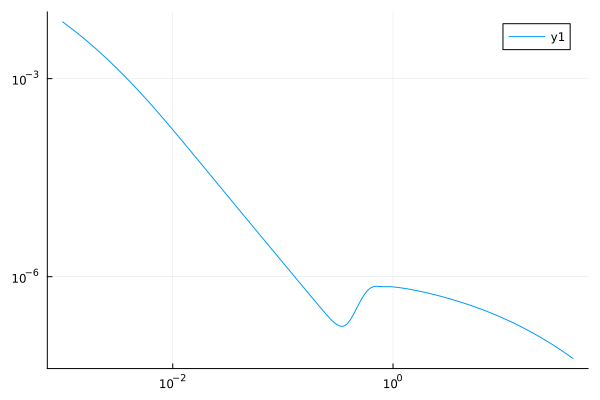

In [50]:
plot(rr, w00[:,5], xscale=:log10, yscale=:log10)

In [56]:
function my_f!!(result1, ℓ, χ, kmin, kmax, c)
    @time for i in 1:nχ
        Threads.@threads for j in i:nχ
            benchmark_f(x) = Bessels.sphericalbesselj.(ℓ, χ[i] * x) * Bessels.sphericalbesselj.(ℓ, χ[j] * x) * myPk(x) * x^2
            integral!(result1, benchmark_f, kmin, kmax, i, j)
        end
        println(i)
    end
end

my_f!! (generic function with 1 method)

In [57]:
nχ = 100
ℓ = 5
result1 = zeros(nχ, nχ)
my_f!!(result1, ℓ, χ, kmin, kmax, c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
 51.445335 seconds (177.15 k allocations: 12.167 MiB, 6.31% compilation time)


┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: Invalid negative or zero value -2.6808143428684533e-12 found at series index 46 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


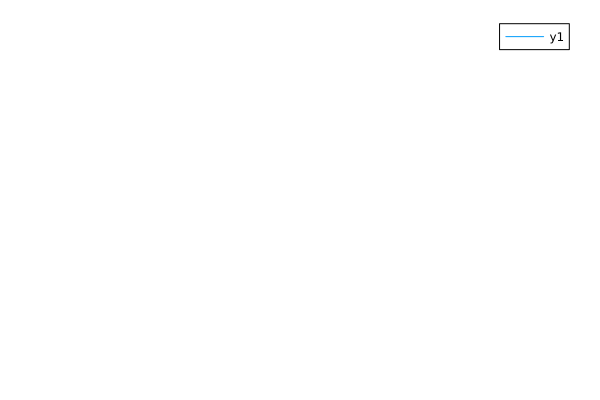

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: Invalid negative or zero value -2.6808143428684533e-12 found at series index 46 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: Invalid negative or zero value -2.6808143428684533e-12 found at series index 46 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/utils.jl:106


In [54]:
plot(χ, diag(result1), xscale=:log10, yscale=:log10)

In [55]:
diag(result1)

100-element Vector{Float64}:
  6.951317179667109e-7
  5.055531069509735e-8
  1.637204228538952e-8
  7.802521043755745e-9
  4.508324747850203e-9
  2.924598212024362e-9
  2.047233500782809e-9
  1.5093923366444252e-9
  1.1604520655461427e-9
  9.220819012389211e-10
  7.472172076359474e-10
  6.139677530397946e-10
  5.263080747517302e-10
  ⋮
  1.3186245184672089e-11
 -1.3733247019304093e-11
  4.1449619104695923e-11
 -1.8453395724323747e-11
  2.431415821193487e-11
  7.888738466313353e-14
  2.1494498367130913e-11
  1.6231222588466343e-11
 -2.106590069282116e-12
  1.7508085087661967e-11
 -1.0478423674109056e-11
  1.561405260419742e-11

In [65]:
y = besselj_zero(5, 3)

15.70017407971167

In [69]:
Bessels.sphericalbesselj.(4.5, y)

5.134949045224661e-17

In [13]:
kmin
kmax

15.384615384615385

# ...then start again from here

In [19]:
ℓ = 2
idx = -2
χ_list = LinRange(23,7000,60)
result_Ia = zeros(length(χ_list))
result_Ib = zeros(length(χ_list))
result_pquad = zeros(length(χ_list))

Threads.@threads for i in 1:length(χ_list)
    Ia, Ea = quadosc(x->myPk(x, χ_list[i], χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
    #Ib, Eb = quadosc(x->myPk(x, χ_list[i], χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
    pquad = Cubature.pquadrature(x->myPk(x, χ_list[i], χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmin, 2*kmax;
                          reltol=sqrt(1e-12), abstol=0, maxevals=2^19)[1]
    result_Ia[i] = Ia
    #result_Ib[i] = Ib
    result_pquad[i] = pquad
end

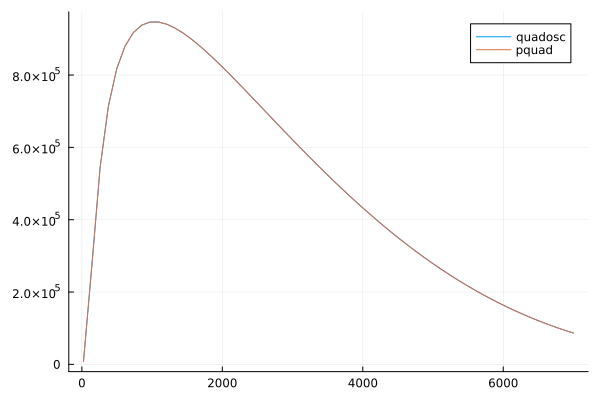

In [20]:
plot(χ_list, result_Ia, label = "quadosc")
plot!(χ_list, result_pquad, label = "pquad")

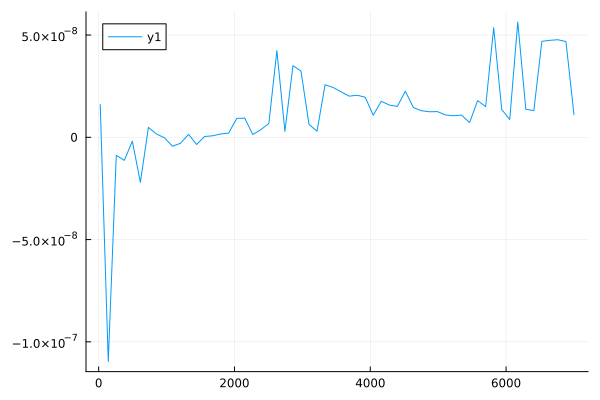

In [21]:
plot(χ_list, 1 .- result_Ia./result_pquad)